# Import Libraries

In [7]:
import torch
import spacy
import torch.nn as nn
import torch.functional as F
import numpy as np
import re
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch import optim
from scripts.helpers import RNN, predict, load_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
intent_model = torch.load('../clean_data/models/intents_classifier.pth')
entity_model = spacy.load('../clean_data/models/ner_model')

In [9]:
def get_intents_and_entites(text):
    intent_prob = -np.inf
    intents_pred = predict(text, intent_model)
    intent = ''

    for item in intents_pred:
        if item[0] > intent_prob:
            intent_prob = item[0]
            intent = item[1]
    ner_doc = entity_model(text)
    entities = [(ent.text, ent.label_) for ent in ner_doc.ents]
    return intent, entities

In [10]:
text = "The patient was prescribed 500 mg of Metformin."
intent, entities = get_intents_and_entites(text)
print(intent)
print(entities)

search_blood_pressure_by_patient_id
[('500 mg', 'DOSAGE'), ('Metformin', 'MEDICATION')]


In [11]:
entities[0]

('500 mg', 'DOSAGE')

In [12]:
INTENT_PREFIX = "[INTENT]"
ENTITY_PREFIX = "[ENTITY]"

In [13]:
def augment_input_with_intent_and_entities(user_input, intent, entities):
    # Augment the input with the intent
    augmented_input = f"{INTENT_PREFIX}{intent} " + user_input
    
    # Augment the input with entities
    for entity, entity_type in entities:
        augmented_input += f" {ENTITY_PREFIX}{entity_type}"
    
    return augmented_input

In [14]:
# Example usage
user_input = "How much Metformin should I take?"
intent = "dosage_query"
entities = [('500 mg', 'DOSAGE'), ('Metformin', 'MEDICATION')]

augmented_input = augment_input_with_intent_and_entities(user_input, intent, entities)

In [15]:
augmented_input

'[INTENT]dosage_query How much Metformin should I take? [ENTITY]DOSAGE [ENTITY]MEDICATION'

----

seq2seq

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.relu = nn.ReLU()

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        if target_tensor is not None:
            sequence_length = target_tensor.size(1)  # Use the length of the target tensor
        else:
            sequence_length = 10 # Arbitrary value

        for i in range(sequence_length):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = self.softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = self.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [18]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = self.softmax(scores)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        if target_tensor is not None:
            sequence_length = target_tensor.size(1)  # Use the length of the target tensor
        else:
            sequence_length = 10 # Arbitrary value

        for i in range(sequence_length):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = self.softmax(decoder_outputs)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [19]:
SOS_token = 0
EOS_token = 1

class Sentence:
    def __init__(self, content):
        self.content = content
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [20]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [21]:
def makePairs():
    print("Reading lines...")
    
    inputs, responses = load_data('../../clean_data/intents_enriched.json')

    # make pairs of input and response and normalize
    pairs = []
    for tag in responses:
        for i in range(len(responses[tag])):
            _, entities = get_intents_and_entites(inputs[tag][i])
            augmented_input = augment_input_with_intent_and_entities(normalizeString(inputs[tag][i]), tag, entities)
            pairs.append([augmented_input, normalizeString(responses[tag][i])])
        
    input_sentence = Sentence('inputs')
    output_sentence = Sentence('responses')

    return input_sentence, output_sentence, pairs

In [22]:
def prepareData():
    input, output, pairs = makePairs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.content, input.n_words)
    print(output.content, output.n_words)
    return input, output, pairs

input, output, pairs = prepareData()
print(random.choice(pairs))

Reading lines...


Read 213 sentence pairs
Counting words...
Counted words:
inputs 151
responses 135
['[INTENT]thanks Thanks for helping me You re a treasure [ENTITY]BODY_PART', 'Happy to help What else can I do for you today ?']


In [23]:
max_length = 0
for pair in pairs:
    if len(pair[0].split(' ')) > max_length:
        max_length = len(pair[0].split(' '))
    if len(pair[1].split(' ')) > max_length:
        max_length = len(pair[1].split(' '))

In [24]:
max_length += 1
max_length

26

In [25]:
def indexesFromSentence(obj, sentence):
    return [obj.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(obj, sentence):
    indexes = indexesFromSentence(obj, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input, pair[0])
    target_tensor = tensorFromSentence(output, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData()

    n = len(pairs)
    input_ids = np.zeros((n, max_length), dtype=np.int32)
    target_ids = np.zeros((n, max_length), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [26]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [27]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [28]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [30]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [31]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input:', pair[0])
        print('Target:', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input, output)
        output_sentence = ' '.join(output_words)
        print('Output:', output_sentence)
        print('')

Reading lines...
Read 213 sentence pairs
Counting words...
Counted words:
inputs 151
responses 135
0m 8s (- 2m 0s) (5 6%) 2.2528
0m 10s (- 1m 11s) (10 12%) 1.2729
0m 12s (- 0m 53s) (15 18%) 0.8032
0m 14s (- 0m 43s) (20 25%) 0.5337
0m 16s (- 0m 36s) (25 31%) 0.4078
0m 18s (- 0m 31s) (30 37%) 0.3292
0m 20s (- 0m 26s) (35 43%) 0.2762
0m 22s (- 0m 22s) (40 50%) 0.2375
0m 25s (- 0m 19s) (45 56%) 0.2109
0m 27s (- 0m 16s) (50 62%) 0.1888
0m 29s (- 0m 13s) (55 68%) 0.1712
0m 31s (- 0m 10s) (60 75%) 0.1555
0m 33s (- 0m 7s) (65 81%) 0.1430
0m 35s (- 0m 5s) (70 87%) 0.1304
0m 37s (- 0m 2s) (75 93%) 0.1196
0m 39s (- 0m 0s) (80 100%) 0.1092


<Figure size 640x480 with 0 Axes>

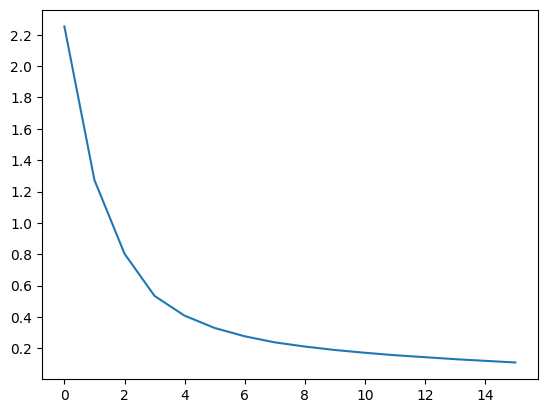

In [32]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [33]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

Input: [INTENT]goodbye So long !
Target: Have a wonderful day
Output: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

Input: [INTENT]goodbye So long ! Have a good one [ENTITY]TEST_NAME
Target: And you as well Please come again
Output: And you as well Please come again <EOS>

Input: [INTENT]goodbye Bye ! Take care [ENTITY]TEST_NAME
Target: You as well Have an amazing day
Output: You also Have a marvelous day <EOS>

Input: [INTENT]goodbye Ciao ! Thanks again [ENTITY]TEST_NAME
Target: No need to thank me Have a splendid day
Output: No need to thank me Have a splendid day <EOS>

Input: [INTENT]thanks Thanks so much
Target: My pleasure What else can I do for you ?
Output: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

Input: [INTENT]goodbye Bye bye ! [ENTITY]TEST_NAME
Target: Have a marvelous day
Output: Have an excellent day <EOS>

Input: [INTENT]thanks Thank you so much You re a treasure [ENTITY]MEDICATION [ENTITY]BODY_PART
Target: No need to thank me How else can I help you ?
Output: SOS SOS SOS SOS 

In [34]:
def process_input(text):
    intent, entities = get_intents_and_entites(text)
    augmented_input = augment_input_with_intent_and_entities(normalizeString(text), intent, entities)
    return augmented_input

input = [INTENT]options Hello How are you ? [ENTITY]TEST_NAME
output = I m glad to be of service How can I


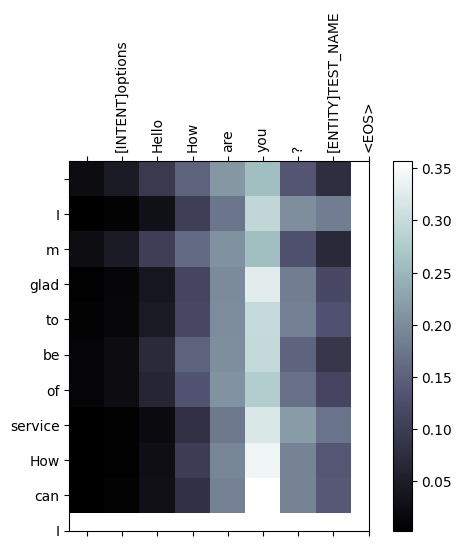

input = [INTENT]search_blood_pressure_by_patient_id Bye Have a good day [ENTITY]TEST_NAME
output = And you as well Please come again <EOS>


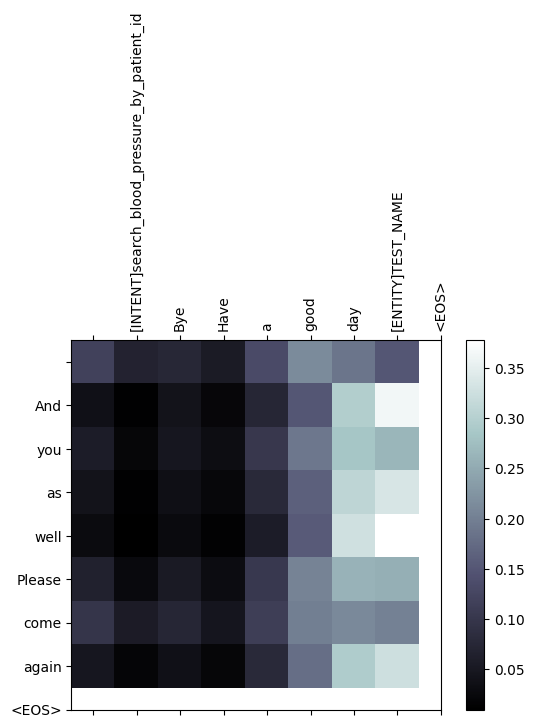

input = [INTENT]search_blood_pressure_by_patient_id What can you do for me ? [ENTITY]MEDICATION
output = I can help you with the adverse drug reaction list


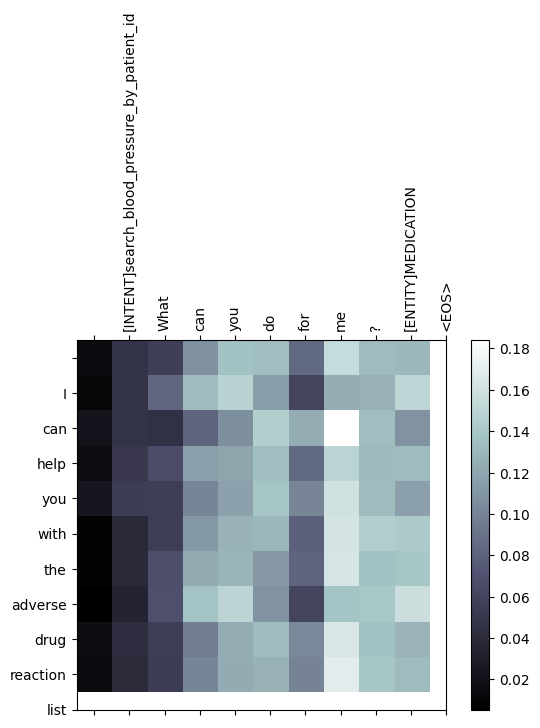

input = [INTENT]hospital_search Find me a hospital nearby [ENTITY]TEST_NAME
output = Please provide hospital type <EOS>


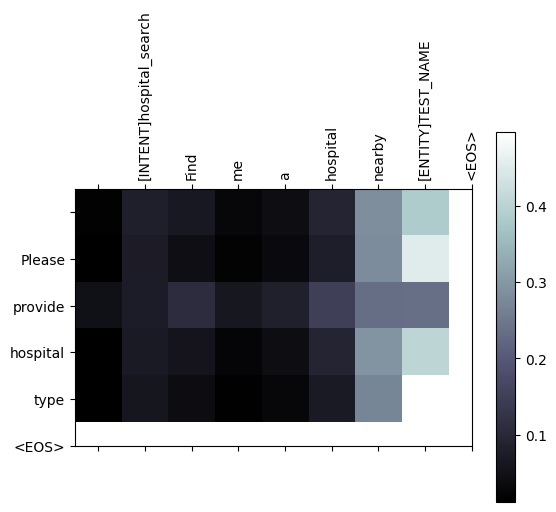

In [35]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(input_sentence.split(' ')) + 2))
    ax.set_yticks(np.arange(len(output_words) + 1))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention(process_input('Hello. How are you?'))

evaluateAndShowAttention(process_input('Bye. Have a good day.'))

evaluateAndShowAttention(process_input('What can you do for me?'))

evaluateAndShowAttention(process_input('Find me a hospital nearby.'))

-----